In [16]:
import re
import random
import pandas as pd
import hashlib

In [17]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [18]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'mean'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
"Mexican Gothic, Moreno-Garcia",353.768087,12.634575,23.226473,28
Azure Functions Core Tools,313.432636,18.437214,34.436762,17
Django,1442.833040,36.070826,49.235366,40
Node.js and Vite,1481.325265,36.129885,58.365516,41
OAuth 2.0 RFC6749,73.575117,36.787558,45.327934,2
Azure Files Documentation,2934.720244,48.912004,145.858656,60
CCH Tax Forms Project,1185.922274,56.472489,125.317337,21
Active Directory and Azure Files,2107.503222,56.959547,104.206456,37
Python + Oauth2.0,1494.084914,64.960214,147.525590,23
Accounting,1136.316265,66.842133,127.912592,17


# Histogram

sum of ages: ~54143.66


<Axes: >

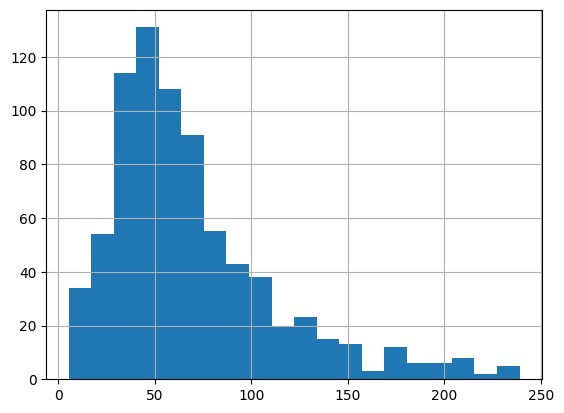

In [19]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~54143.66


<Axes: >

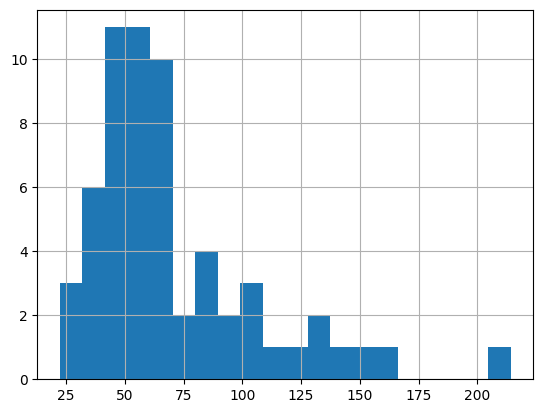

In [20]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Python']['age'].hist(bins=20)

# Completely Random Shuffle

In [21]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [22]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [23]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [24]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 781
Total card age: 54143.66


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
216,C# Basics,"How do you use LINQ methods like Select, Where...",ff833626ef0ff2ba5ca7a1def3dc6b58,-210.528653,-105.772415,210.528653,1269.268984,0.263985,12,0,0
217,C# Basics,What is LINQ in C# and how is it used?\n\nC#:\...,60df0823b58dc817984a22d9ee376852,-126.487930,-105.772415,210.528653,1269.268984,0.263985,12,3,0
218,C# Basics,What is the syntax for a for loop in C#?\n\nC#...,b007dd02bc671a50d0e254dd81f8dbee,-87.572105,-105.772415,210.528653,1269.268984,0.263985,12,6,0
219,C# Basics,How is a class defined in C#?\n\nC#:\npublic c...,91893bec56379ca61e53987ad22c5a91,-59.410491,-105.772415,210.528653,1269.268984,0.263985,12,9,0
83,Vocab,"Something Rotten, Fforde\nOwen Wister\n\nAn Am...",6a562f5734764178c0e8b1f11d0c3540,-233.180107,-103.782938,233.180107,3632.402817,0.464304,35,0,0
84,Vocab,"Something Rotten, Fforde\nCreosote\nnoun | KRE...",c3b2baf38a6685dcc4c76629ca54d94b,-193.695084,-103.782938,233.180107,3632.402817,0.464304,35,3,0
85,Vocab,"How to Sell a Haunted House, Hendrix\nTruckle\...",4607d91573be7dc69c866124bf221e6d,-169.750548,-103.782938,233.180107,3632.402817,0.464304,35,6,0
86,Vocab,"Well of Lost Plots, Fforde\n(naval) Pinnance\n...",a49b67777f8f6b92f6aa53f702817098,-141.566938,-103.782938,233.180107,3632.402817,0.464304,35,9,0
357,Vocab,"Well of Lost Plots, Fforde\nLych-gate\nnoun | ...",a79c049cddc049b36a63f7ddab18741f,-103.209880,-103.782938,233.180107,3632.402817,0.464304,35,12,0
88,Vocab,"Something Rotten, Fforde\nBrocade (dress)\nnou...",5779ed3ba5605d0786578fbf87d737bd,-93.604632,-103.782938,233.180107,3632.402817,0.464304,35,15,0


## Age Max

In [25]:
# n = 5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [26]:
# n=5
# # existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [27]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [28]:
existing_cards.head(10)['age'].sum()

np.float64(-1419.0063685847751)

In [29]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
95,PnP PowerShell,App-Only Authentication\nA mode where applicat...,12d9bc97a1e6f53d3b7295eb85274bad,-238.941844,-91.176181,238.941844,3099.990161,0.695470,34,0,0
67,Terraform Codebox,A cloud-init.yaml.tpl file is a template for p...,e86be4b765ffee839b385a1a96ac3db1,-235.764444,-82.658899,235.764444,3884.968240,0.638963,47,0,0
127,Power BI,Why can’t you reference a newly added column a...,a550364578e3469f2990bdec6904efc0,-233.715853,-80.339007,233.715853,2570.848235,0.953769,32,0,0
83,Vocab,"Something Rotten, Fforde\nOwen Wister\n\nAn Am...",6a562f5734764178c0e8b1f11d0c3540,-233.180107,-103.782938,233.180107,3632.402817,0.464304,35,0,0
14,CCH Axcess,Security groups with any level of rights can b...,78f3ef96be8d308e501c9a70a0bc0c56,-230.009304,-87.564741,230.009304,5078.754993,0.769696,58,0,0
285,CCH Axcess,Enable AutoText descriptions\nAllows you to cr...,5d78f7e45fe2c0dbf42b9c87b93c2224,-219.473183,-87.564741,230.009304,5078.754993,0.769696,58,1,1
337,Terraform Codebox,Azure Files can be used to persist your coding...,9775a34a34e3610d8ddc43c1e0b44268,-217.065544,-82.658899,235.764444,3884.968240,0.638963,47,1,1
167,Azure Compute Gallery,"Managed Image – A single, region-bound image s...",4099811ce9ab63014bfbe9d3999b3e32,-214.427731,-90.641706,214.427731,1631.550706,0.684452,18,0,0
262,Python,Q:\nWhat method do you call to parse the comma...,58c3e5284b8e017e25b1fe16b13cb52b,-214.276436,-71.093520,214.276436,4265.611204,0.186100,60,0,0
365,PnP PowerShell,REST API Endpoints\nSpecific URLs used to acce...,b12f5012328f32a6c689485970705806,-213.373660,-91.176181,238.941844,3099.990161,0.695470,34,1,1


In [30]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 69.326'